In [69]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
from IPython.display import HTML
#https://www.kaggle.com/datasets/gauravduttakiit/coffee-leaf-diseases?select=test

In [70]:
BATCH_SIZE = 32
IMAGE_SIZEx = 256
IMAGE_SIZEy=256
CHANNELS=3
EPOCHS=10

In [71]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "train",
    seed=123,
    shuffle=True,
    image_size=(IMAGE_SIZEx,IMAGE_SIZEy),
    batch_size=BATCH_SIZE
)


Found 1264 files belonging to 4 classes.


In [72]:
class_names = dataset.class_names
class_names

['miner', 'nodisease', 'phoma', 'rust']

In [73]:
len(dataset)

40

In [74]:
train_size = 0.8
len(dataset)*train_size

32.0

In [75]:
train_ds = dataset.take(13)
len(train_ds)

13

In [76]:
test_ds = dataset.skip(13)
len(test_ds)

27

In [77]:
val_size=0.1
len(dataset)*val_size

4.0

In [78]:
val_ds = test_ds.take(1)
len(val_ds)

1

In [79]:
test_ds = test_ds.skip(1)
len(test_ds)

26

In [80]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1

    ds_size = len(ds)

    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)

    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)

    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)

    return train_ds, val_ds, test_ds

In [81]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [82]:
len(train_ds)

32

In [83]:
len(val_ds)

4

In [84]:
len(test_ds)

4

In [85]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [86]:
from tensorflow.keras import models, layers
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(IMAGE_SIZEx, IMAGE_SIZEy),
  layers.experimental.preprocessing.Rescaling(1./255),
])

In [87]:
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
])

In [88]:
train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)

In [89]:
import tensorflow as tf
from tensorflow.keras import models, layers
CHANNELS = 3

input_shape = (BATCH_SIZE, IMAGE_SIZEx, IMAGE_SIZEy, CHANNELS)
n_classes = 4

model = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)

In [90]:
model.summary()


Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_3 (Sequential)   (32, 256, 256, 3)         0         
                                                                 
 conv2d_6 (Conv2D)           (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d_6 (MaxPoolin  (32, 127, 127, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_7 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_7 (MaxPoolin  (32, 62, 62, 64)          0         
 g2D)                                                            
                                                                 
 conv2d_8 (Conv2D)           (32, 60, 60, 64)         

In [91]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [92]:
# Define early stopping callback
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

# Train the model
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=EPOCHS,
    callbacks=[early_stopping]
)

Epoch 1/10
32/32 [==============================] - 99s 2s/step - loss: 1.3631 - accuracy: 0.2907 - val_loss: 1.3083 - val_accuracy: 0.3828
Epoch 2/10
32/32 [==============================] - 56s 2s/step - loss: 1.2225 - accuracy: 0.4425 - val_loss: 1.2211 - val_accuracy: 0.4922
Epoch 3/10
32/32 [==============================] - 56s 2s/step - loss: 1.0091 - accuracy: 0.5665 - val_loss: 1.0598 - val_accuracy: 0.5312
Epoch 4/10
32/32 [==============================] - 56s 2s/step - loss: 0.8215 - accuracy: 0.6994 - val_loss: 0.7326 - val_accuracy: 0.6719
Epoch 5/10
32/32 [==============================] - 57s 2s/step - loss: 0.5863 - accuracy: 0.7798 - val_loss: 0.4549 - val_accuracy: 0.8750
Epoch 6/10
32/32 [==============================] - 58s 2s/step - loss: 0.4777 - accuracy: 0.8353 - val_loss: 0.3487 - val_accuracy: 0.8672
Epoch 7/10
32/32 [==============================] - 58s 2s/step - loss: 0.3843 - accuracy: 0.8571 - val_loss: 0.2619 - val_accuracy: 0.9141
Epoch 8/10
32/32 [==

In [93]:
scores = model.evaluate(test_ds)

4/4 [==============================] - 5s 394ms/step - loss: 0.2332 - accuracy: 0.9297


In [94]:
scores


[0.23319971561431885, 0.9296875]

In [95]:
history.params

{'verbose': 1, 'epochs': 10, 'steps': 32}

In [96]:
history.history.keys()


dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [97]:
type(history.history['loss'])


list

In [98]:
len(history.history['accuracy'])


10

In [99]:
history.history['val_accuracy']

[0.3828125,
 0.4921875,
 0.53125,
 0.671875,
 0.875,
 0.8671875,
 0.9140625,
 0.90625,
 0.6796875,
 0.8984375]

In [100]:
history.history['loss'][:5]

[1.3630541563034058,
 1.2224531173706055,
 1.0091232061386108,
 0.8215333223342896,
 0.5863375067710876]

In [102]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']


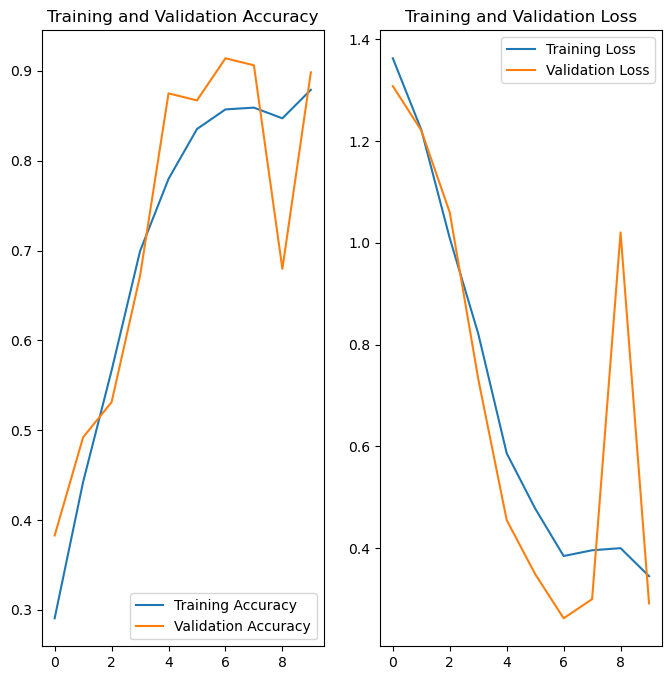

In [103]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()


first image to predict
actual label: nodisease
1/1 [==============================] - 0s 469ms/step
predicted label: nodisease


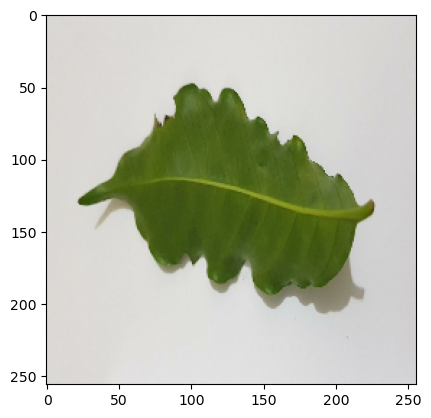

In [104]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):

    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()

    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])

    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

In [106]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 [==============================] - 0s 32ms/step


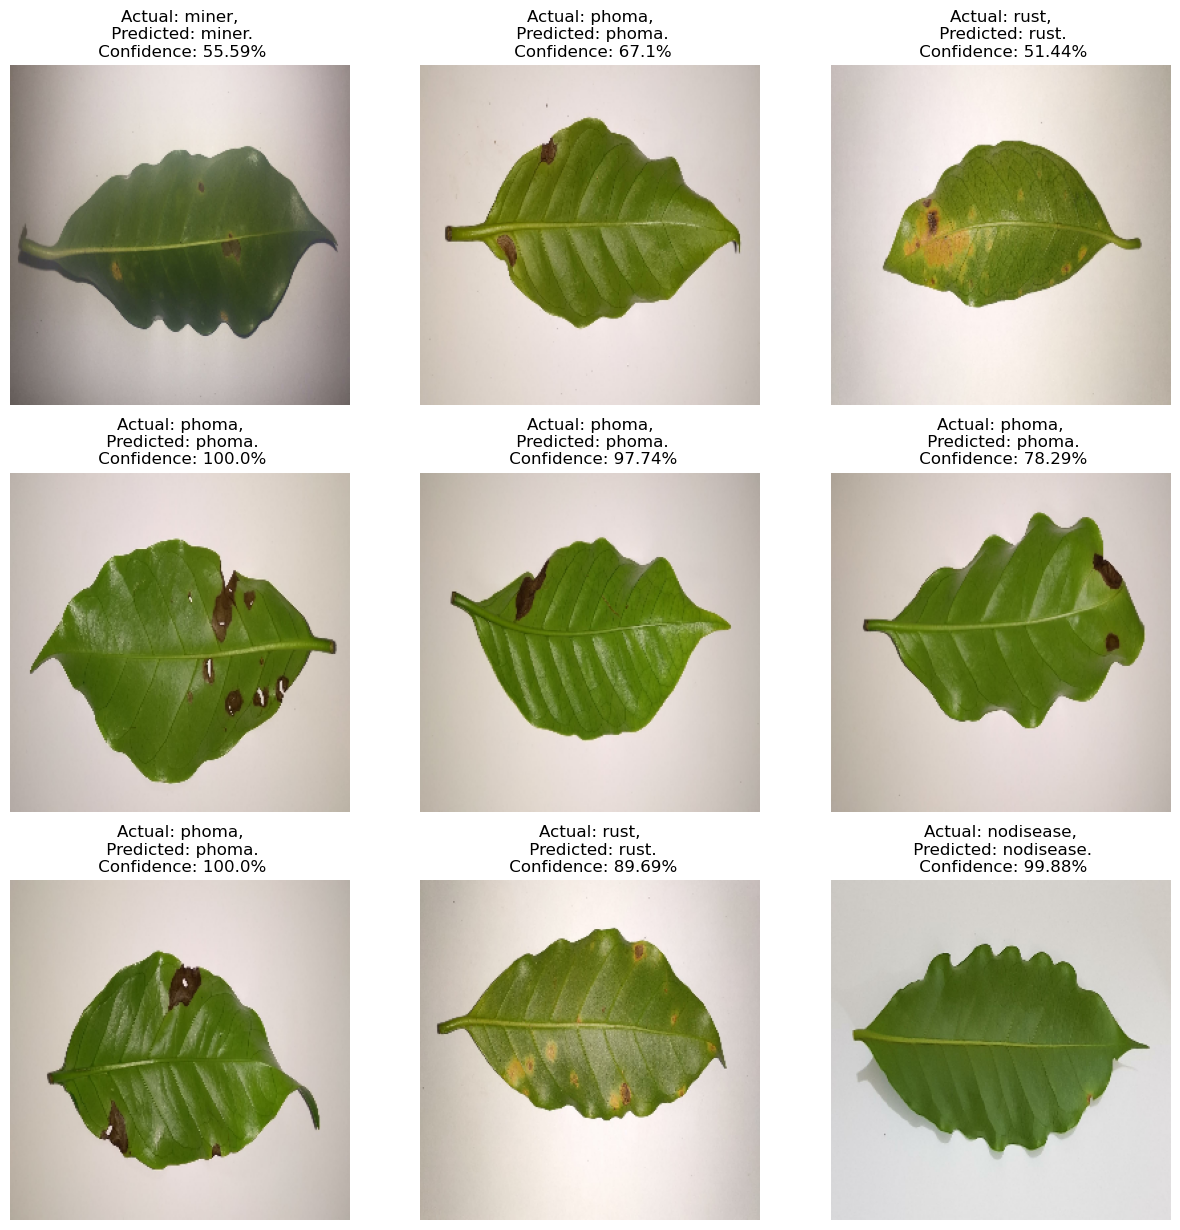

In [107]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))

        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]]

        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")

        plt.axis("off")

In [108]:
model_version = 10
model.save(r"C:\Users\frede\agricultura\model\10")

INFO:tensorflow:Assets written to: C:\Users\frede\agricultura\model\10\assets


INFO:tensorflow:Assets written to: C:\Users\frede\agricultura\model\10\assets
